# Cluster by accessory gene expression

This notebook is visualizing the expression of accessory genes in the PAO1 and PA14 compendia

In [1]:
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from core_acc_modules import paths_explore, utils

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Load data

Raw data was processed in an external repository by a member of the Hogan lab: https://github.com/hoganlab-dartmouth/pa-seq-compendia

The basic processing steps to process the data were as follows:
1. _P. aeruginosa_ transcriptome data was downloaded from SRA (~4K samples)
2. Aligned and quantified samples using Salmon against PAO1 and PA14 references
3. Quantified results were validated by performing a differential expression analysis and comparing the DEGs against the original publication.
4. Samples were removed if:
    * Less than 1000 genes with 0 counts
    * median count <10
_Note:_
* Not sure yet where this data will permanently be stored but there are plans to share it. Currently this is being housed locally to run this analysis

In [2]:
# Expression data files
pao1_expression_filename = paths_explore.PAO1_GE
pa14_expression_filename = paths_explore.PA14_GE

# File containing table to map sample id to strain name
sample_to_strain_filename = paths_explore.SAMPLE_TO_STRAIN

In [3]:
# Load expression data
# Matrices will be sample x gene after taking the transpose
pao1_expression = pd.read_csv(pao1_expression_filename, index_col=0, header=0).T

pa14_expression = pd.read_csv(pa14_expression_filename, index_col=0, header=0).T

# Drop row with gene ensembl ids
pao1_expression.drop(["X"], inplace=True)
pa14_expression.drop(["X"], inplace=True)

In [4]:
print(pao1_expression.shape)
pao1_expression.head()

(2643, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571.ERX541571.salmon,186.695,41.0399,52.6869,42.5596,11.8271,49.6818,15.1125,18.9761,39.7944,7.90016,...,0,5.16485,8.34185,2.24955,16.7872,35.8977,35.3801,117.821,133.373,0
ERX541572.ERX541572.salmon,200.587,36.65,65.5425,40.1072,15.0975,38.9103,9.27882,13.3374,35.814,4.29789,...,0,4.02765,8.1123,2.13563,13.5472,21.0032,26.6635,109.515,99.2929,0
ERX541573.ERX541573.salmon,111.42,27.4148,56.0137,25.2659,18.6952,22.6177,7.28033,8.25073,22.8004,2.72297,...,0,3.55578,8.70387,2.63218,20.6529,13.5422,33.1718,47.4317,34.1095,0
ERX541574.ERX541574.salmon,143.32,34.4773,83.4517,39.3797,23.2258,30.0783,12.3878,11.1666,26.4343,7.74561,...,0,7.79597,9.47563,4.12049,16.6373,15.0784,24.8545,97.8814,36.5146,5.00512
ERX541575.ERX541575.salmon,118.398,34.014,73.7324,32.2136,21.2469,23.1491,6.74443,13.0066,33.6489,4.74327,...,0,5.56938,9.57055,2.4523,32.6727,8.08117,47.4864,66.6335,26.2999,0


In [5]:
print(pa14_expression.shape)
pa14_expression.head()

(2619, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571.ERX541571.salmon,7.649,5.19946,0,0.60384,3.25146,2.07243,4.73741,9.29522,14.7829,0.799833,...,12.9614,59.3176,216.062,15.6344,62.0945,12.2478,485.023,7.89171,20.5447,0
ERX541572.ERX541572.salmon,9.07994,5.32769,1.81816,2.99295,8.57561,2.01307,2.62795,11.8476,20.8028,1.0461,...,22.1461,83.6427,201.195,21.1028,90.7961,77.918,643.011,13.0426,18.0631,0
ERX541573.ERX541573.salmon,8.19844,5.34884,5.74693,6.51464,4.44288,4.59846,1.40991,11.5351,15.8012,3.56081,...,22.5625,113.387,140.01,8.23511,17.6324,75.5676,989.102,15.9628,11.4278,0
ERX541574.ERX541574.salmon,10.2302,1.51737,2.20543,3.78442,2.16879,4.43033,2.52313,9.35498,18.8926,2.66614,...,28.664,120.056,179.671,8.44258,20.247,72.9086,1107.97,24.7304,28.1454,0
ERX541575.ERX541575.salmon,8.83536,5.10013,2.70427,7.34835,4.38874,3.05368,0.652771,7.40535,11.4972,1.66304,...,14.6011,125.629,111.88,7.18445,16.4272,58.6684,720.376,17.0733,24.7502,0


In [6]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)
sample_to_strain_table_full.head()

,Unnamed: 0,Run,Sample.Name,SRA_study,BioProject,GEO_Accession..exp.,source_name,Strain,PAO1,PA14,PAK,ClinicalIsolate
Experiment,,,,,,,,,,,,
SRX5057740,1,SRR8239475,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057739,2,SRR8239476,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057910,3,SRR8239645,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX5057909,4,SRR8239646,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX3573046,5,SRR6483189,PAO1 samples from Colistin/Doripenem treatment,SRP130183,PRJNA414673,NaN,NaN,PAO1,True,False,False,False


## Process data

In [7]:
# Format expression data indices so that values can be mapped to `sample_to_strain_table`
pao1_index_processed = pao1_expression.index.str.split(".").str[0]
pa14_index_processed = pa14_expression.index.str.split(".").str[0]

pao1_expression.index = pao1_index_processed
pa14_expression.index = pa14_index_processed

In [8]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,186.695,41.0399,52.6869,42.5596,11.8271,49.6818,15.1125,18.9761,39.7944,7.90016,...,0,5.16485,8.34185,2.24955,16.7872,35.8977,35.3801,117.821,133.373,0
ERX541572,200.587,36.65,65.5425,40.1072,15.0975,38.9103,9.27882,13.3374,35.814,4.29789,...,0,4.02765,8.1123,2.13563,13.5472,21.0032,26.6635,109.515,99.2929,0
ERX541573,111.42,27.4148,56.0137,25.2659,18.6952,22.6177,7.28033,8.25073,22.8004,2.72297,...,0,3.55578,8.70387,2.63218,20.6529,13.5422,33.1718,47.4317,34.1095,0
ERX541574,143.32,34.4773,83.4517,39.3797,23.2258,30.0783,12.3878,11.1666,26.4343,7.74561,...,0,7.79597,9.47563,4.12049,16.6373,15.0784,24.8545,97.8814,36.5146,5.00512
ERX541575,118.398,34.014,73.7324,32.2136,21.2469,23.1491,6.74443,13.0066,33.6489,4.74327,...,0,5.56938,9.57055,2.4523,32.6727,8.08117,47.4864,66.6335,26.2999,0


In [9]:
pa14_expression.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571,7.649,5.19946,0,0.60384,3.25146,2.07243,4.73741,9.29522,14.7829,0.799833,...,12.9614,59.3176,216.062,15.6344,62.0945,12.2478,485.023,7.89171,20.5447,0
ERX541572,9.07994,5.32769,1.81816,2.99295,8.57561,2.01307,2.62795,11.8476,20.8028,1.0461,...,22.1461,83.6427,201.195,21.1028,90.7961,77.918,643.011,13.0426,18.0631,0
ERX541573,8.19844,5.34884,5.74693,6.51464,4.44288,4.59846,1.40991,11.5351,15.8012,3.56081,...,22.5625,113.387,140.01,8.23511,17.6324,75.5676,989.102,15.9628,11.4278,0
ERX541574,10.2302,1.51737,2.20543,3.78442,2.16879,4.43033,2.52313,9.35498,18.8926,2.66614,...,28.664,120.056,179.671,8.44258,20.247,72.9086,1107.97,24.7304,28.1454,0
ERX541575,8.83536,5.10013,2.70427,7.34835,4.38874,3.05368,0.652771,7.40535,11.4972,1.66304,...,14.6011,125.629,111.88,7.18445,16.4272,58.6684,720.376,17.0733,24.7502,0


In [10]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full.index):
    if sample_to_strain_table_full.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif sample_to_strain_table_full.loc[exp_id, "ClinicalIsolate"].all() == True:
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full["Strain type"].to_frame()

In [11]:
sample_to_strain_table.head()

,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


In [12]:
# What are the NA strains?
print(sample_to_strain_table.shape)
na_sample_ids = list(
    sample_to_strain_table[sample_to_strain_table["Strain type"] == "NA"].index
)
print(len(na_sample_ids))

(3013, 1)
831


In [13]:
# Most of these strains don't have strain annotation available
sample_to_strain_table_full.loc[na_sample_ids, "Strain"].isnull().sum()

579

In [14]:
# Use to manually lookup these experiments in SRA
# sample_to_strain_table_full.loc[na_sample_ids, "Strain"]

In [15]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,186.695,41.0399,52.6869,42.5596,11.8271,49.6818,15.1125,18.9761,39.7944,7.90016,...,0,5.16485,8.34185,2.24955,16.7872,35.8977,35.3801,117.821,133.373,0
ERX541572,200.587,36.65,65.5425,40.1072,15.0975,38.9103,9.27882,13.3374,35.814,4.29789,...,0,4.02765,8.1123,2.13563,13.5472,21.0032,26.6635,109.515,99.2929,0
ERX541573,111.42,27.4148,56.0137,25.2659,18.6952,22.6177,7.28033,8.25073,22.8004,2.72297,...,0,3.55578,8.70387,2.63218,20.6529,13.5422,33.1718,47.4317,34.1095,0
ERX541574,143.32,34.4773,83.4517,39.3797,23.2258,30.0783,12.3878,11.1666,26.4343,7.74561,...,0,7.79597,9.47563,4.12049,16.6373,15.0784,24.8545,97.8814,36.5146,5.00512
ERX541575,118.398,34.014,73.7324,32.2136,21.2469,23.1491,6.74443,13.0066,33.6489,4.74327,...,0,5.56938,9.57055,2.4523,32.6727,8.08117,47.4864,66.6335,26.2999,0


## Get core and accessory genes

In [16]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths_explore.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pao1")

In [17]:
# Get mapping between PAO1 and PA14 genes using PA14 reference
gene_annot_file = paths_explore.GENE_PA14_ANNOT
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pa14")

In [18]:
# Get core genes: genes that have a homolog between PAO1 and PA14
core_pao1_genes, core_pa14_genes = utils.get_core_genes(
    gene_mapping_pao1, gene_mapping_pa14, False
)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")
print(f"Number of PA14 core genes: {len(core_pa14_genes)}")

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363


In [19]:
# Select only core genes that are included in my dataset
pao1_ref_genes = pao1_expression.columns
my_core_pao1_genes = list(set(core_pao1_genes).intersection(pao1_ref_genes))

print(f"Number of PAO1 core genes in my dataset: {len(my_core_pao1_genes)}")

Number of PAO1 core genes in my dataset: 5361


In [20]:
# Select only core genes that are included in my dataset
pa14_ref_genes = pa14_expression.columns
my_core_pa14_genes = list(set(core_pa14_genes).intersection(pa14_ref_genes))

print(f"Number of PA14 core genes in my dataset: {len(my_core_pa14_genes)}")

Number of PA14 core genes in my dataset: 5361


In [21]:
# Get PAO1-specific genes
pao1_acc = list(set(pao1_ref_genes) - set(my_core_pao1_genes))
print(f"Number of PAO1-specific genes: {len(pao1_acc)}")

Number of PAO1-specific genes: 202


In [22]:
## TO DO: Get PA14-specific genes
pa14_acc = list(set(pa14_ref_genes) - set(my_core_pa14_genes))
print(f"Number of PA14-specific genes: {len(pa14_acc)}")

Number of PA14-specific genes: 530


## Create df for plotting

In [23]:
# Merge strain to expression matrix
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)

pao1_expression_label.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX1272616,303.826,338.798,465.777,397.257,123.078,116.112,27.6101,92.3953,120.1,65.3267,...,27.2083,92.8974,33.9391,71.2049,657.254,1486.1,392.344,130.88,0,NA
ERX1272617,330.188,396.435,355.406,510.354,122.091,97.4159,54.6994,136.763,120.483,69.5939,...,38.5745,83.0111,44.8906,85.2286,756.769,849.959,412.308,107.523,0,NA
ERX1272618,135.018,243.605,387.461,326.783,62.5105,87.8338,100.757,41.0638,25.4338,47.1923,...,89.8114,1060.36,90.2585,51.5689,233.097,117.328,155.28,219.262,0,NA
ERX1272619,137.16,244.026,439.474,339.497,56.7303,85.7355,101.12,48.4013,28.0883,46.4248,...,94.4059,999.594,73.5905,54.9011,227.787,129.853,165.439,148.655,0,NA
ERX1296067,140.57,88.7564,146.913,92.2535,68.5016,188.014,51.1262,48.819,90.7225,75.2857,...,318.793,127.164,120.941,0.179352,237.866,682.149,239.442,471.95,24.2662,NA


In [24]:
# Create core dataframe with columns:
# core gene ids | median core expression | strain label

# PAO1
pao1_core_expression_label = pao1_expression_label[my_core_pao1_genes + ["Strain type"]]
pao1_core_expression = pao1_expression_label[my_core_pao1_genes]
pao1_core_expression_label["median core expression"] = pao1_core_expression.median(
    axis=1
)

# PA14
pa14_core_expression_label = pa14_expression_label[my_core_pa14_genes + ["Strain type"]]
pa14_core_expression = pa14_expression_label[my_core_pa14_genes]
pa14_core_expression_label["median core expression"] = pa14_core_expression.median(
    axis=1
)

pao1_core_expression_label.head()

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,PA0485,PA2131,PA3999,PA3578,PA0467,PA2502,PA0836,PA1590,PA2962,PA5504,...,PA3423,PA4627,PA1344,PA3186,PA0982,PA2986,PA2701,PA3900,Strain type,median core expression
ERX1272616,60.4549,1.89125,287.754,80.9823,36.9275,16.5955,200.03,264.043,66.4689,145.147,...,24.2531,26.6325,46.0934,3419.75,9.18502,114.674,4.18749,48.6171,NA,45.600280
ERX1272617,59.9283,2.08862,342.615,79.142,55.074,15.035,190.019,225.448,90.318,180.45,...,18.1898,27.4457,80.2341,7497.32,11.0399,108.858,8.46512,67.2706,NA,54.732095
ERX1272618,155.197,6.42746,177.031,983.818,104.054,12.9131,202.719,67.1964,91.8077,46.7772,...,79.5714,29.3422,57.9623,62.8072,11.4201,36.5913,15.2686,9.68448,NA,67.938024
ERX1272619,168.323,7.20623,166.022,682.107,94.4893,14.4093,192.534,77.9188,90.3484,52.6053,...,67.0077,30.1821,62.5092,65.4959,11.7409,32.9062,13.7023,8.15962,NA,67.436206
ERX1296067,58.6244,46.0038,92.1587,64.2346,29.0149,53.3294,64.119,96.8732,46.9286,99.303,...,75.5692,59.2073,39.1093,114.754,0,74.2502,28.3613,15.9419,NA,64.113645


In [25]:
pa14_core_expression_label.head()

,PA14_10870,PA14_73290,PA14_42200,PA14_65180,PA14_05960,PA14_47440,PA14_17690,PA14_54370,PA14_49440,PA14_58470,...,PA14_55480,PA14_25440,PA14_05810,PA14_31810,PA14_37090,PA14_55490,PA14_04890,PA14_24810,Strain type,median core expression
ERX1272616,3.67611,1075.23,754.036,2337.17,24301.4,114.196,63.6088,205.116,42.6401,223.378,...,2.42673,142.701,8.97256,231.762,13.5736,3.73319,44.6361,9.91119,NA,41.409632
ERX1272617,3.79413,1498.12,905.549,2490.78,16171.7,205.541,61.7761,219.046,40.4956,361.673,...,2.75276,201.833,16.4495,284.595,18.9337,3.59554,59.2945,16.3139,NA,53.904251
ERX1272618,11.1757,104.244,3189.6,456.198,39083.3,419.04,43.3583,67.6442,31.6608,91.9484,...,9.83241,56.8128,132.779,314.933,41.5304,12.6786,37.4074,38.1035,NA,64.120510
ERX1272619,11.2107,124.862,3237.55,546.828,40086.4,390.956,36.9498,67.8971,28.2101,80.3353,...,8.51902,63.141,101.898,309.532,28.1464,12.4524,37.1283,41.2694,NA,63.276096
ERX1296067,91.2756,591.447,708.88,1033.56,5404.59,54.1367,78.0205,242.156,35.0065,48.728,...,28.257,38.7608,49.529,145.569,36.4975,54.2669,59.4535,62.6006,NA,71.066616


In [26]:
# Merge PAO1 and PA14 core dataframes
pao1_pa14_core_expression_label = pao1_core_expression_label.merge(
    pa14_core_expression_label,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_core_expression_label.head()

,PA0485,PA2131,PA3999,PA3578,PA0467,PA2502,PA0836,PA1590,PA2962,PA5504,...,PA14_55480,PA14_25440,PA14_05810,PA14_31810,PA14_37090,PA14_55490,PA14_04890,PA14_24810,Strain type_pa14,median core expression_pa14
ERX1272616,60.4549,1.89125,287.754,80.9823,36.9275,16.5955,200.03,264.043,66.4689,145.147,...,2.42673,142.701,8.97256,231.762,13.5736,3.73319,44.6361,9.91119,NA,41.409632
ERX1272617,59.9283,2.08862,342.615,79.142,55.074,15.035,190.019,225.448,90.318,180.45,...,2.75276,201.833,16.4495,284.595,18.9337,3.59554,59.2945,16.3139,NA,53.904251
ERX1272618,155.197,6.42746,177.031,983.818,104.054,12.9131,202.719,67.1964,91.8077,46.7772,...,9.83241,56.8128,132.779,314.933,41.5304,12.6786,37.4074,38.1035,NA,64.120510
ERX1272619,168.323,7.20623,166.022,682.107,94.4893,14.4093,192.534,77.9188,90.3484,52.6053,...,8.51902,63.141,101.898,309.532,28.1464,12.4524,37.1283,41.2694,NA,63.276096
ERX1296067,58.6244,46.0038,92.1587,64.2346,29.0149,53.3294,64.119,96.8732,46.9286,99.303,...,28.257,38.7608,49.529,145.569,36.4975,54.2669,59.4535,62.6006,NA,71.066616


In [27]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression_label = pao1_expression_label[pao1_acc + ["Strain type"]]
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression_label["median acc expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression_label = pa14_expression_label[pa14_acc + ["Strain type"]]
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression_label["median acc expression"] = pa14_acc_expression.median(axis=1)

pao1_acc_expression_label.head()

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,PA1383,PA0205,PA1151,PA4555,PA3841,PA3362,PA0453,PA5264,PA0053,PA2733,...,PA1938,PA0977,PA2294,PA0826.1,PA2819,PA3147,PA4105,PA1371,Strain type,median acc expression
ERX1272616,0,7.71311,1523.53,225.778,24.9792,34.2285,26.7839,77.7916,223.496,0,...,178.039,54.8148,6.59513,0,116.401,0,0,0,NA,9.432793
ERX1272617,0,9.24272,751.517,191.263,24.691,75.022,32.4799,57.5393,240.589,0,...,162.717,33.9571,19.948,0,51.6789,0,0,0,NA,10.622970
ERX1272618,0,44.9511,1797.59,687.564,57.2888,123.663,296.884,193.552,340.691,0,...,209.085,12.0107,14.7781,0,47.7863,0,0,0,NA,18.488467
ERX1272619,0,42.0104,1648.48,393.677,56.4377,112.946,286.594,240.18,357.23,0,...,187.242,11.6552,14.8582,0,55.5444,0,0,0,NA,16.115071
ERX1296067,0.036102,90.5358,0,0.104602,62.1526,349.589,72.7963,314.193,0,0.367528,...,605.668,0,33.3179,176414,219.527,0.140608,29.6061,0,NA,21.065359


In [28]:
pa14_acc_expression_label.head()

,PA14_03166,PA14_71760,PA14_53100,PA14_69350,PA14_59870,PA14_54960,PA14_55240,PA14_13210,PA14_53450,PA14_04010,...,PA14_19930,PA14_59160,PA14_28850,PA14_59720,PA14_04350,PA14_59290,PA14_36020,PA14_15160,Strain type,median acc expression
ERX1272616,0,187.627,11.9378,211.573,9.78832,0,14.6623,0,586.892,498.933,...,14.4716,15.699,145.583,0,38.9428,16.6398,17.9806,28.8571,NA,0.000000
ERX1272617,0,191.062,11.2254,248.975,7.04776,0,17.1163,0,268.822,503.099,...,14.8195,16.5547,118.115,0,50.5584,16.5784,24.2487,22.6894,NA,0.000000
ERX1272618,0,141.469,82.2214,791.612,18.1966,0,43.6331,0,312.603,169.427,...,493.869,22.4713,222.033,0,71.5309,18.0568,29.5768,67.0458,NA,0.000000
ERX1272619,0,158.961,63.1293,815.417,13.349,0,50.2653,0,296.824,184.828,...,877.517,21.7976,192.141,0,70.2258,16.4985,26.6333,64.7394,NA,0.000000
ERX1296067,0,110.262,192.043,163.933,0,0,13.9976,0.582515,509.246,225.204,...,83.591,0,190.362,0.04114,53.9796,0.039091,12.6771,31.8813,NA,0.111727


In [29]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression_label = pao1_acc_expression_label.merge(
    pa14_acc_expression_label,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression_label.head()

,PA1383,PA0205,PA1151,PA4555,PA3841,PA3362,PA0453,PA5264,PA0053,PA2733,...,PA14_19930,PA14_59160,PA14_28850,PA14_59720,PA14_04350,PA14_59290,PA14_36020,PA14_15160,Strain type_pa14,median acc expression_pa14
ERX1272616,0,7.71311,1523.53,225.778,24.9792,34.2285,26.7839,77.7916,223.496,0,...,14.4716,15.699,145.583,0,38.9428,16.6398,17.9806,28.8571,NA,0.000000
ERX1272617,0,9.24272,751.517,191.263,24.691,75.022,32.4799,57.5393,240.589,0,...,14.8195,16.5547,118.115,0,50.5584,16.5784,24.2487,22.6894,NA,0.000000
ERX1272618,0,44.9511,1797.59,687.564,57.2888,123.663,296.884,193.552,340.691,0,...,493.869,22.4713,222.033,0,71.5309,18.0568,29.5768,67.0458,NA,0.000000
ERX1272619,0,42.0104,1648.48,393.677,56.4377,112.946,286.594,240.18,357.23,0,...,877.517,21.7976,192.141,0,70.2258,16.4985,26.6333,64.7394,NA,0.000000
ERX1296067,0.036102,90.5358,0,0.104602,62.1526,349.589,72.7963,314.193,0,0.367528,...,83.591,0,190.362,0.04114,53.9796,0.039091,12.6771,31.8813,NA,0.111727


## Plot: core genome

In [30]:
# Drop label columns
pao1_expression_numeric = pao1_expression_label.drop(["Strain type"], axis=1)
pa14_expression_numeric = pa14_expression_label.drop(["Strain type"], axis=1)

In [31]:
# Embed expression data into low dimensional space
pca = PCA(n_components=2)
# model_pao1 = umap.UMAP(random_state=123).fit(pao1_expression_numeric)
model_pao1 = pca.fit(pao1_expression_numeric)
pao1_encoded = model_pao1.transform(pao1_expression_numeric)

pao1_encoded_df = pd.DataFrame(
    data=pao1_encoded, index=pao1_expression_numeric.index, columns=["1", "2"]
)

# Add back label
pao1_encoded_df["Strain_type"] = pao1_expression_label["Strain type"]

In [32]:
model_pa14 = pca.fit(pa14_expression_numeric)
# model_pa14 = umap.UMAP(random_state=123).fit(pa14_expression_numeric)
pa14_encoded = model_pa14.transform(pa14_expression_numeric)

pa14_encoded_df = pd.DataFrame(
    data=pa14_encoded, index=pa14_expression_numeric.index, columns=["1", "2"]
)

# Add back label
pa14_encoded_df["Strain_type"] = pa14_expression_label["Strain type"]

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


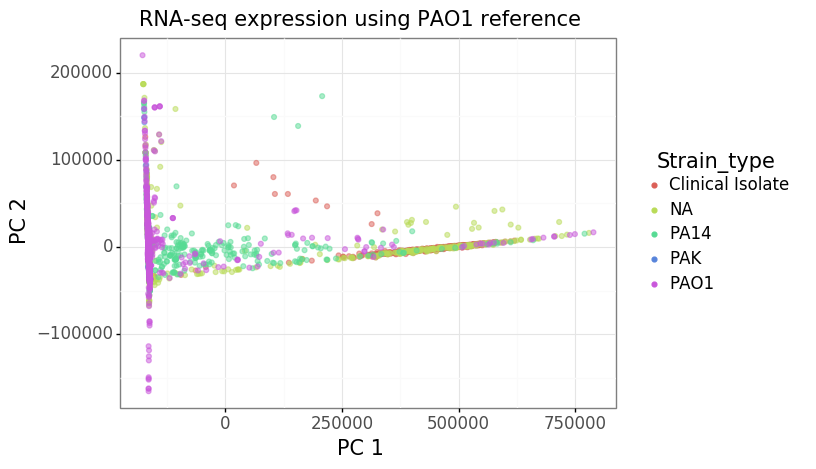

<ggplot: (8791308297605)>


In [33]:
# Plot PAO1
fig = pn.ggplot(pao1_encoded_df, pn.aes(x="1", y="2"))
fig += pn.geom_point(pn.aes(color="Strain_type"), alpha=0.5)
fig += pn.labs(x="PC 1", y="PC 2", title="RNA-seq expression using PAO1 reference")
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

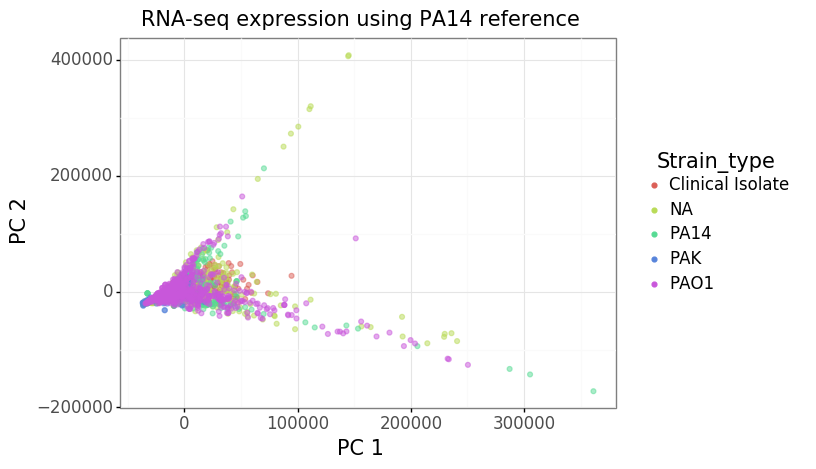

<ggplot: (8791308302741)>


In [34]:
# Plot PAO1
fig = pn.ggplot(pa14_encoded_df, pn.aes(x="1", y="2"))
fig += pn.geom_point(pn.aes(color="Strain_type"), alpha=0.5)
fig += pn.labs(x="PC 1", y="PC 2", title="RNA-seq expression using PA14 reference")
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

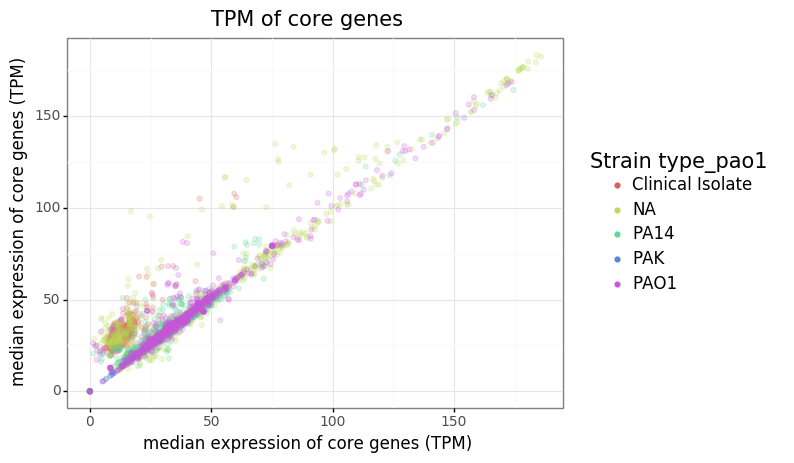

<ggplot: (8791308424501)>


In [35]:
# Plot
fig = pn.ggplot(
    pao1_pa14_core_expression_label,
    pn.aes(x="median core expression_pao1", y="median core expression_pa14"),
)
fig += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.2)
fig += pn.labs(
    x="median expression of core genes (TPM)",
    y="median expression of core genes (TPM)",
    title="TPM of core genes",
)
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


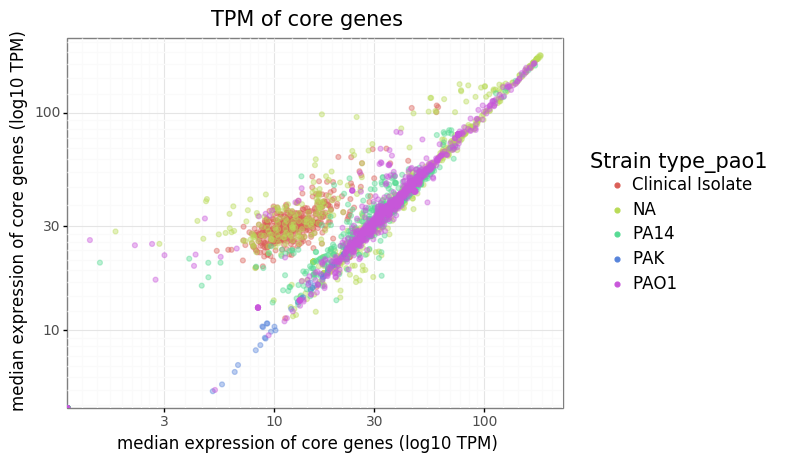

<ggplot: (8791308372257)>


In [36]:
# Plot log-scaled
fig2 = pn.ggplot(
    pao1_pa14_core_expression_label,
    pn.aes(x="median core expression_pao1", y="median core expression_pa14"),
)
fig2 += pn.scales.scale_x_log10()
fig2 += pn.scales.scale_y_log10()
fig2 += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.4)
fig2 += pn.labs(
    x="median expression of core genes (log10 TPM)",
    y="median expression of core genes (log10 TPM)",
    title="TPM of core genes",
)
fig2 += pn.theme_bw()
fig2 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig2 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))


print(fig2)

**Takeaway:**
* This is a positive control that core genes are expressed in both PAO1 and PA14 samples

* Based on expression profiles of core genes in PAO1 vs PA14 samples, there doesn't look to be a clear clustering amongst PAO1 and PA14 samples. Is this expected?

## Plot: accessory genome

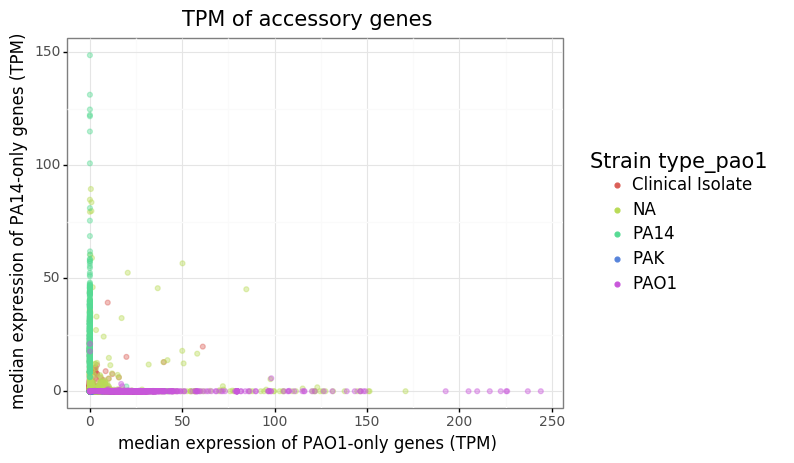

<ggplot: (8791308330949)>


In [37]:
# Plot
fig3 = pn.ggplot(
    pao1_pa14_acc_expression_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig3 += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.4)
fig3 += pn.labs(
    x="median expression of PAO1-only genes (TPM)",
    y="median expression of PA14-only genes (TPM)",
    title="TPM of accessory genes",
)
fig3 += pn.theme_bw()
fig3 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig3 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig3)

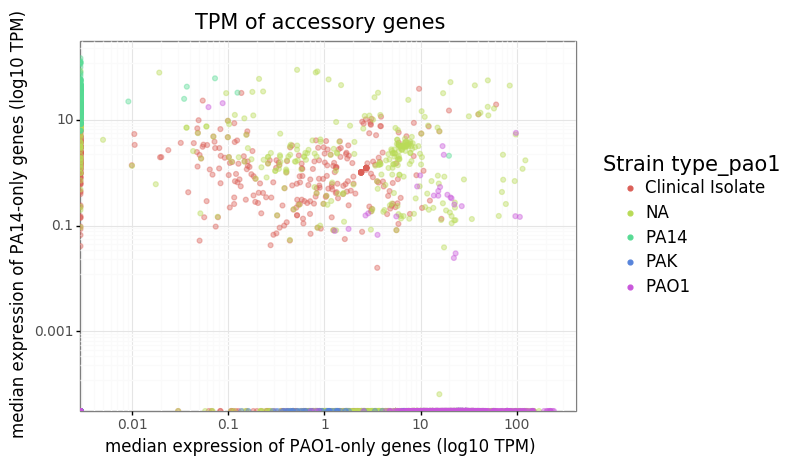

<ggplot: (8791292826481)>


In [38]:
# Plot log-scaled
fig4 = pn.ggplot(
    pao1_pa14_acc_expression_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig4 += pn.scales.scale_x_log10()
fig4 += pn.scales.scale_y_log10()
fig4 += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.4)
fig4 += pn.labs(
    x="median expression of PAO1-only genes (log10 TPM)",
    y="median expression of PA14-only genes (log10 TPM)",
    title="TPM of accessory genes",
)
fig4 += pn.theme_bw()
fig4 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig4 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))


print(fig4)

**Note:**
We can compare TPM between PAO1 and PA14 if they have similar total number of reads mapped. So perhaps we can compare PAO1 and PA14 compendia. See Georgia’s [google doc](https://docs.google.com/document/d/1OnvJNVkhK5ATnhHaeSmz8Ze_Iw9ixXhfSxAL_BSqbuM/edit)

**Takeaway:**
* This is a positive control that PAO1 annotated samples have higher median expression of PAO1-only genes compared to PA14-only genes. And similarly, PA14 annotated samples have higher median expression of PA14-only genes compared to PAO1-only genes. In other words, we expect that PA14-only genes will have either 0 or very low values in PAO1 samples and vice versa.

* This result also shows that we can anticipate a very clear binning of our samples into PAO1 and PA14 if we use mapping rates.

* Note: The NA strains are those where the strain information was not available in the metadata. By a quick manual spot check it looks like a bunch were clinical isolates (which is good since these NA seem to cluster with other clinical isolates).

### How many samples have a very low or 0 expression?

In [50]:
# Total number of PAO1 samples
num_pao1_samples = (pao1_pa14_acc_expression_label["Strain type_pao1"] == "PAO1").sum()
print(f"Number of PAO1 samples is {num_pao1_samples}")

# Total number of PA14 samples
num_pa14_samples = (pao1_pa14_acc_expression_label["Strain type_pao1"] == "PA14").sum()
print(f"Number of PA14 samples if {num_pa14_samples}")
print("\n\n")

# Of those samples, how many have o or low expression?
threshold = 50
pao1_sample_ids = pao1_pa14_acc_expression_label["Strain type_pao1"] == "PAO1"
pao1_acc_expression_label = pao1_pa14_acc_expression_label.loc[pao1_sample_ids]
pao1_core_expression_label = pao1_pa14_core_expression_label.loc[pao1_sample_ids]

print("----- Matching sample and reference statistics -------")
pao1_acc_expression_low = pao1_acc_expression_label[
    pao1_acc_expression_label["median acc expression_pao1"] == 0
]
print(
    f"Proportion of PAO1 samples with 0 median PAO1-only expression: {pao1_acc_expression_low.shape[0]/num_pao1_samples}"
)
pao1_acc_expression_low = pao1_acc_expression_label[
    pao1_acc_expression_label["median acc expression_pao1"] < threshold
]
print(
    f"Proportion of PAO1 samples with median PAO1-only expression < {threshold}: {pao1_acc_expression_low.shape[0]/num_pao1_samples}"
)
pao1_core_expression_low = pao1_core_expression_label[
    pao1_core_expression_label["median core expression_pao1"] < threshold
]
print(
    f"Proportion of PAO1 samples with median core expression < {threshold}: {pao1_core_expression_low.shape[0]/num_pao1_samples}"
)

pa14_sample_ids = pao1_pa14_acc_expression_label["Strain type_pao1"] == "PA14"
pa14_acc_expression_label = pao1_pa14_acc_expression_label.loc[pa14_sample_ids]
pa14_core_expression_label = pao1_pa14_core_expression_label.loc[pa14_sample_ids]

pa14_acc_expression_low = pa14_acc_expression_label[
    pa14_acc_expression_label["median acc expression_pa14"] == 0
]
print(
    f"Proportion of PA14 samples with 0 median PA14-only expression: {pa14_acc_expression_low.shape[0]/num_pa14_samples}"
)
pa14_acc_expression_low = pa14_acc_expression_label[
    pa14_acc_expression_label["median acc expression_pa14"] < threshold
]
print(
    f"Proportion of PA14 samples with median PA14-only expression < {threshold}: {pa14_acc_expression_low.shape[0]/num_pa14_samples}"
)
pa14_core_expression_low = pa14_core_expression_label[
    pa14_core_expression_label["median core expression_pa14"] < threshold
]
print(
    f"Proportion of PA14 samples with median core expression < {threshold}: {pa14_core_expression_low.shape[0]/num_pa14_samples}"
)
print("\n\n")

print("----- mis-matching sample and reference statistics -------")
pa14_acc_expression_low = pa14_acc_expression_label[
    pa14_acc_expression_label["median acc expression_pao1"] == 0
]
print(
    f"Proportion of PA14 samples with 0 median PAO1-only expression: {pa14_acc_expression_low.shape[0]/num_pa14_samples}"
)
pao1_acc_expression_low = pao1_acc_expression_label[
    pao1_acc_expression_label["median acc expression_pa14"] == 0
]
print(
    f"Proportion of PAO1 samples with 0 median PA14-only expression: {pao1_acc_expression_low.shape[0]/num_pao1_samples}"
)

Number of PAO1 samples is 920
Number of PA14 samples if 563



----- Matching sample and reference statistics -------
Proportion of PAO1 samples with 0 median PAO1-only expression: 0.008695652173913044
Proportion of PAO1 samples with median PAO1-only expression < 50: 0.9163043478260869
Proportion of PAO1 samples with median core expression < 50: 0.8326086956521739
Proportion of PA14 samples with 0 median PA14-only expression: 0.08348134991119005
Proportion of PA14 samples with median PA14-only expression < 50: 0.9609236234458259
Proportion of PA14 samples with median core expression < 50: 0.9094138543516874



----- mis-matching sample and reference statistics -------
Proportion of PA14 samples with 0 median PAO1-only expression: 0.9769094138543517
Proportion of PAO1 samples with 0 median PA14-only expression: 0.9717391304347827


27.8536425
491.824254


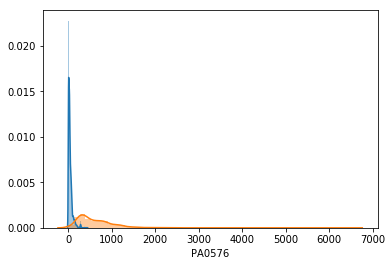

In [51]:
# Examine distribution of expression of individual core genes
# some genes that are considered "housekeeping" genes that you
# might expect to be pretty consistently expressed at decently high levels:
# PA1805 (ppiD), PA0576 (rpoD), PA4368 (rpsL), PA3622 (rpoS), PA3617 (recA)
sns.distplot(pao1_pa14_core_expression_label["PA0485"])
print(pao1_pa14_core_expression_label["PA0485"].median())
sns.distplot(pao1_pa14_core_expression_label["PA0576"])
print(pao1_pa14_core_expression_label["PA0576"].median())

6.267656
0.09312899999999999


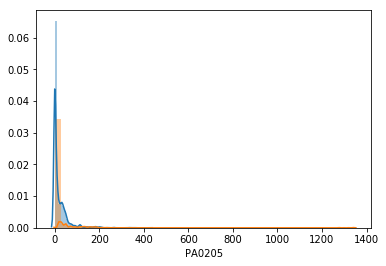

In [47]:
# Examine distribution of expression of individual accessory genes
sns.distplot(pao1_pa14_acc_expression_label["PA1383"])
print(pao1_pa14_acc_expression_label["PA1383"].median())
sns.distplot(pao1_pa14_acc_expression_label["PA0205"])
print(pao1_pa14_acc_expression_label["PA0205"].median())

**Takeaway:**
* Most samples have below 50 TPM, which is expected for accessory genes given the strong skewing toward 0
* As expected, PA14 samples tend to have 0 expression of PAO1-only genes. And similarly for PAO1 samples

### Examine samples on the diagonal
* Curious about the samples that have expression of both PAO1 and PA14 specific genes. Mostly clinical isolates, but some PAO1 and PA14 samples.
* Our binning will likely remove these samples, so we just want to make sure we know who they are before we do

In [41]:
# Get samples with high expression of both PAO1 and PA14 specific genes
pao1_pa14_acc_expression_label[
    (pao1_pa14_acc_expression_label["median acc expression_pao1"] > 30)
    & (pao1_pa14_acc_expression_label["median acc expression_pa14"] > 30)
]

,PA1383,PA0205,PA1151,PA4555,PA3841,PA3362,PA0453,PA5264,PA0053,PA2733,...,PA14_19930,PA14_59160,PA14_28850,PA14_59720,PA14_04350,PA14_59290,PA14_36020,PA14_15160,Strain type_pa14,median acc expression_pa14
SRX6437625,0,0.060454,112.53,207.425,138.205,179.211,118.148,169.006,83.3095,0,...,82.1764,429.522,58.8512,0,101.315,199.527,168.607,57.0434,NA,45.098928
SRX6437734,346.044,0,0,470.543,0.487447,354.391,111.991,1.12216,0,0,...,49.6519,696.71,254.638,0,96.6182,182.533,23.6725,62.5568,NA,56.568645
SRX6437785,146.371,0,0,354.428,119.366,344.779,94.2902,273.859,0,0,...,35.396,568.884,165.291,0,103.051,182.474,134.812,57.4663,NA,45.575088


About selected samples:
* All samples are from [Thoming et. al. publication](https://pubmed.ncbi.nlm.nih.gov/31934344/), where clinical isolates were grown in planktonic and biofilm conditions

Not much I could find about these samples other than they are clinical isolates that seem to have acquired accessory genes from both PAO1 and PA14, which is interesting!

In [54]:
# Get PAO1 samples with high expression of PA14 specific genes
pao1_acc_expression_label[pao1_acc_expression_label["median acc expression_pa14"] > 10]

,PA1383,PA0205,PA1151,PA4555,PA3841,PA3362,PA0453,PA5264,PA0053,PA2733,...,PA14_19930,PA14_59160,PA14_28850,PA14_59720,PA14_04350,PA14_59290,PA14_36020,PA14_15160,Strain type_pa14,median acc expression_pa14
SRX5290923,0.043201,0,0.916748,2.51966,1.07368,0.551232,2.19175,0.046989,2.03101,0,...,8.14139,2.17612,515.603,2.50576,85.2129,3.74552,11.4016,13.5349,PAO1,17.636860
SRX5290924,0.039124,0,1.06273,0.848181,1.56698,0.654977,4.60645,0.088626,0.311654,0.124316,...,2.81271,7.27898,717.657,3.36609,83.6332,5.25648,9.12076,15.2416,PAO1,20.945177


In [55]:
# Get PA14 samples with high expression of PAO1 specific genes
pa14_acc_expression_label[pa14_acc_expression_label["median acc expression_pao1"] > 10]

,PA1383,PA0205,PA1151,PA4555,PA3841,PA3362,PA0453,PA5264,PA0053,PA2733,...,PA14_19930,PA14_59160,PA14_28850,PA14_59720,PA14_04350,PA14_59290,PA14_36020,PA14_15160,Strain type_pa14,median acc expression_pa14
SRX4326016,12.6423,7.68254,546.811,173.157,4557.12,14.9055,10.7765,69.3655,98.0845,45.2279,...,4.3822,3.90608,8.77034,0.47586,29.4576,0.18049,18.7985,21.3138,PA14,2.112724
SRX5099522,51.5314,36.1136,1109.37,231.622,59.4036,42.6339,57.8698,196.272,406.447,892.206,...,18.262,0,40.7834,0,51.0644,0,32.0823,31.3784,PA14,0.000000
SRX5099523,49.48,24.3814,2376.48,216.417,34.8588,24.4736,67.1672,211.498,468.135,1010.06,...,38.4156,0,18.6202,0,56.7655,0,18.7807,15.1691,PA14,0.000000
SRX5099524,57.0244,28.6251,1097.48,231.842,52.3012,35.5503,80.1294,212.648,481.213,988.808,...,48.938,0,14.6511,0,67.7165,0,21.3664,23.7315,PA14,0.000000
SRX7423386,33.4265,21.8196,2567.61,151.399,33.7969,62.5122,23.2281,26.8546,145.972,79.0686,...,153.126,0,5.26591,0,38.4457,0,8.78863,45.7227,PA14,0.000000
SRX7423388,33.6743,21.4196,2317.53,184.972,40.667,82.1232,21.0961,24.0769,134.763,73.1118,...,151.527,0,9.6937,0,37.7623,0,7.8108,45.1983,PA14,0.000000


### Other observations
* PA14 seem to have more clinical isolates
* PAK and PAO1 closer, is that expected?
* Why is range of PA14 and PAO1 different?